In [129]:
import requests
import os
import pandas as pd
import random
from datetime import datetime
from bs4 import BeautifulSoup
import re
import nltk
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns


### Fetching Data on Financial Statements

In [ ]:
# Replace with your actual API key
api_key = 'UQn515JfZbBngOBe7tyMcYB2evhMq40D'
symbols = ['AAPL', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']

# Directory to save scraped HTML content
folder_path = 'financial_statements_html'
os.makedirs(folder_path, exist_ok=True)

financial_data = []

# Define the headers with a user-agent
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

def scrape_html_content(url):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.text
    else:
        print(f'Failed to scrape {url} (Status code: {response.status_code})')
        return None

def save_html_content(symbol, date, content):
    filename = f"{symbol}_{date}_financial_statement.html"
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(content)
    print(f'Successfully saved {filename}')
    return file_path

for symbol in symbols:
    url = f'https://financialmodelingprep.com/api/v3/income-statement/{symbol}?apikey={api_key}'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        for statement in data:
            statement['symbol'] = symbol
            
            # Extract HTML URL from 'finalLink'
            html_url = statement.get('finalLink')
            if html_url:
                html_content = scrape_html_content(html_url)
                if html_content:
                    file_path = save_html_content(symbol, statement['date'], html_content)
                    statement['html_file_path'] = file_path  # Include the file path in the statement data
                else:
                    statement['html_file_path'] = None  # Handle case where HTML content couldn't be scraped

            financial_data.append(statement)
    else:
        print(f'Error: Unable to fetch data for {symbol} (Status code: {response.status_code})')

# Convert to DataFrame and save to CSV
df = pd.DataFrame(financial_data)
csv_path = os.path.join(folder_path, 'financial_statements.csv')
df.to_csv(csv_path, index=False)
print(f"Financial data saved to {csv_path}")
print(df.head())

### Cleaning Sentiments Data

In [92]:
tweet_id_company = pd.read_csv('data/sentiments/tweet_company.csv')
full_tweets = pd.read_csv('data/sentiments/Tweet.csv')
companies = pd.read_csv('data/sentiments/Company.csv')

In [93]:
tweets_with_company = pd.merge(tweet_id_company, full_tweets, on='tweet_id', how='left')
tweets_with_company['post_date'] = pd.to_datetime(tweets_with_company['post_date'], unit='s')
tweets_with_company.drop(columns=['tweet_id', 'comment_num', 'retweet_num', 'like_num', 'writer'], inplace=True)
tweets_with_company.head()

,ticker_symbol,post_date,body
0,AAPL,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...
1,AAPL,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...
2,AAPL,2015-01-01 23:58:16,Rumor Roundup: What to expect when you're expe...
3,AAPL,2015-01-01 23:57:13,"An $AAPL store line in Sapporo Japan for the ""..."
4,AAPL,2015-01-01 23:56:48,$AAPL - Will $AAPL Give Second entry opportuni...


In [94]:
tweets_with_company['post_date'] = pd.to_datetime(tweets_with_company['post_date'])
tweets_with_company = tweets_with_company[tweets_with_company['post_date'].dt.year >= 2019]

In [95]:
def random_date(start_date, end_date):
    start_timestamp = int(start_date.timestamp())
    end_timestamp = int(end_date.timestamp())
    random_timestamp = random.randint(start_timestamp, end_timestamp)
    return datetime.fromtimestamp(random_timestamp).strftime('%Y-%m-%d')

In [113]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2022, 3, 31)


tweets_with_company['post_date'] = tweets_with_company['post_date'].apply(lambda x: random_date(start_date, end_date))
tweets_with_company = tweets_with_company.sort_values(by='post_date')

tweets_with_company.to_csv('test.csv', index=False)

In [97]:
tweets_with_company.dropna(inplace=True)

In [98]:
def clean_text(text):
    if pd.isnull(text):
        return ''
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [99]:
tweets_with_company['body'] = tweets_with_company['body'].apply(clean_text)

tweets_with_company['body'] = tweets_with_company['body'].str.lower()

tweets_with_company.to_csv('cleaned_sentiment_dataset.csv', index=False)

### Cleaning Financial Statement Data

In [100]:
financial_statements = pd.read_csv('data/financial_statements/financial_statements.csv')
financial_statements.head()

,date,symbol,reportedCurrency,cik,fillingDate,acceptedDate,calendarYear,period,revenue,costOfRevenue,...,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink,html_file_path
0,2023-09-30,AAPL,USD,320193,2023-11-03,2023-11-02 18:08:27,2023,FY,383285000000,214137000000,...,16741000000,96995000000,0.253062,6.16,6.13,15744231000,15812547000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,NaN
1,2022-09-24,AAPL,USD,320193,2022-10-28,2022-10-27 18:01:14,2022,FY,394328000000,223546000000,...,19300000000,99803000000,0.253096,6.15,6.11,16215963000,16325819000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,NaN
2,2021-09-25,AAPL,USD,320193,2021-10-29,2021-10-28 18:04:28,2021,FY,365817000000,212981000000,...,14527000000,94680000000,0.258818,5.67,5.61,16701272000,16864919000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,NaN
3,2020-09-26,AAPL,USD,320193,2020-10-30,2020-10-29 18:06:25,2020,FY,274515000000,169559000000,...,9680000000,57411000000,0.209136,3.31,3.28,17352119000,17528214000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,NaN
4,2019-09-28,AAPL,USD,320193,2019-10-31,2019-10-30 18:12:36,2019,FY,260174000000,161782000000,...,10481000000,55256000000,0.212381,2.99,2.97,18471336000,18595652000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,NaN


In [101]:
financial_statements.drop(columns=['reportedCurrency', 'cik', 'acceptedDate', 'period', 'link', 'finalLink', 'html_file_path', 'date', 'fillingDate'], inplace=True)

In [102]:
financial_statements.head()

,symbol,calendarYear,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,sellingGeneralAndAdministrativeExpenses,...,totalOtherIncomeExpensesNet,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil
0,AAPL,2023,383285000000,214137000000,169148000000,0.441311,29915000000,0,0,24932000000,...,-565000000,113736000000,0.296740,16741000000,96995000000,0.253062,6.16,6.13,15744231000,15812547000
1,AAPL,2022,394328000000,223546000000,170782000000,0.433096,26251000000,0,0,25094000000,...,-334000000,119103000000,0.302040,19300000000,99803000000,0.253096,6.15,6.11,16215963000,16325819000
2,AAPL,2021,365817000000,212981000000,152836000000,0.417794,21914000000,0,0,21973000000,...,258000000,109207000000,0.298529,14527000000,94680000000,0.258818,5.67,5.61,16701272000,16864919000
3,AAPL,2020,274515000000,169559000000,104956000000,0.382332,18752000000,0,0,19916000000,...,803000000,67091000000,0.244398,9680000000,57411000000,0.209136,3.31,3.28,17352119000,17528214000
4,AAPL,2019,260174000000,161782000000,98392000000,0.378178,16217000000,0,0,18245000000,...,1807000000,65737000000,0.252666,10481000000,55256000000,0.212381,2.99,2.97,18471336000,18595652000


### Cleaning Stock Data

In [103]:
stock_datasets = ['AAPL_Historical_Data.csv', 
                  'AMZN Historical Data.csv',  
                  'GOOGL Historical Data.csv',
                  'MSFT.csv',
                  'TSLA-stock.csv']

In [104]:
apple = pd.read_csv('data/stock_data/'+stock_datasets[0])
amazon = pd.read_csv('data/stock_data/'+stock_datasets[1])
google = pd.read_csv('data/stock_data/'+stock_datasets[2])
microsoft = pd.read_csv('data/stock_data/'+stock_datasets[3])
tesla = pd.read_csv('data/stock_data/'+stock_datasets[4])

stock_dataframes = [apple, amazon, google, microsoft, tesla]

In [105]:
apple['Date'] = pd.to_datetime(apple['Date'])
apple = apple[apple['Date'].dt.year >= 2019]

amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon = amazon[amazon['Date'].dt.year >= 2019]

google['Date'] = pd.to_datetime(google['Date'])
google = google[google['Date'].dt.year >= 2019]

microsoft['Date'] = pd.to_datetime(microsoft['Date'])
microsoft = microsoft[microsoft['Date'].dt.year >= 2019]

tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla = tesla[tesla['Date'].dt.year >= 2019]

### Sentiment Analysis and Further Processing

In [106]:
nltk.download('vader_lexicon')
df_sentiment = pd.read_csv('cleaned_sentiment_dataset.csv')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asare\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [107]:
# Initialize VADER sentiment analyzer
sentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    # Ensure text is a string
    if pd.isnull(text):
        return None
    text = str(text)
    # Get the sentiment scores
    scores = sentimentIntensityAnalyzer.polarity_scores(text)
    # Return the compound score (overall sentiment)
    return scores['compound']

# Apply sentiment analysis
df_sentiment['sentiment'] = df_sentiment['body'].apply(analyze_sentiment)


In [108]:
df_sentiment.head()

,ticker_symbol,post_date,body,sentiment
0,TSLA,2019-01-01,maybe elon needs some help with the tech tsla ...,0.4019
1,AAPL,2019-01-01,join robinhoodapp and well both get a stock li...,0.8860
2,TSLA,2019-01-01,is this true elonmusktsla tslaq,0.4215
3,MSFT,2019-01-01,msft upgraded to buy from hold at jeffries,0.0000
4,AMZN,2019-01-01,nasdaq closed above today will hit in led by g...,0.1779


In [109]:
grouped = df_sentiment.groupby('ticker_symbol')

for ticker, group in grouped:
    filename = f'{ticker}_sentiment_analysis.csv'
    group.to_csv(filename, index=False)


In [110]:
def calculate_monthly_average(df):
    # Ensure the post_date is in datetime format
    df['post_date'] = pd.to_datetime(df['post_date'])
    
    # Extract year and month
    df['year_month'] = df['post_date'].dt.to_period('M')
    
    # Group by year and month, and calculate average sentiment
    monthly_avg = df.groupby('year_month')['sentiment'].mean().reset_index()
    
    # Rename columns for clarity
    monthly_avg.columns = ['Year_Month', 'Average_Sentiment']
    
    return monthly_avg


tickers = ['TSLA', 'AAPL', 'AMZN', 'GOOGL', 'MSFT'] 
monthly_avg_list = []


for ticker in tickers:
    file_path = f'{ticker}_sentiment_analysis.csv'
    df = pd.read_csv(file_path)
    
    # Calculate monthly average sentiment
    monthly_avg = calculate_monthly_average(df)
    
    # Add a column for ticker symbol
    monthly_avg['Ticker'] = ticker
    
    # Append to the list
    monthly_avg_list.append(monthly_avg)

# Concatenate all DataFrames into one
combined_monthly_avg = pd.concat(monthly_avg_list, ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_monthly_avg.to_csv('data/stock_data/combined_monthly_avg_sentiment.csv', index=False)

apple.head()

In [111]:
def calculate_profit_or_loss(df, use_close=True):
    # Convert Date to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract Year and Month
    df['Year_Month'] = df['Date'].dt.to_period('M')
    
    # Determine the price column to use for profit/loss calculation
    price_col = 'Close' if use_close else 'Price'
    
    # Group by Year_Month and calculate the opening and closing prices for each month
    monthly_summary = df.groupby('Year_Month').agg(
        Open_First=('Open', 'first'),
        Close_Last=(price_col, 'last')
    ).reset_index()
    
    # Determine Profit or Loss for each month
    monthly_summary['Profit_or_Loss'] = monthly_summary.apply(
        lambda row: 'Profit' if row['Close_Last'] > row['Open_First'] else 'Loss', axis=1
    )
    
    return monthly_summary

In [125]:
for ticker, stocks in zip(tickers, stock_dataframes):
    # Load the stock data for each ticker
    df = stocks
    
    # Check if the dataset has a 'Close' column to determine the price column to use
    use_close = 'Close' in df.columns
    
    # Calculate profit or loss
    monthly_summary = calculate_profit_or_loss(df, use_close)
    
    # Add a column for the ticker symbol
    monthly_summary['Ticker'] = ticker
    
    # Append to the combined DataFrame
    all_tickers_data = pd.concat([all_tickers_data, monthly_summary], ignore_index=True)

profit_loss_map = {
    "Profit": 1,
    "Loss": 0,
    "Neutral": -1  # if applicable
}
all_tickers_data['Profit_or_Loss'] = all_tickers_data['Profit_or_Loss'].map(profit_loss_map) 
# Save the combined DataFrame to a single CSV file
output_file = 'data/stock_data/all_tickers_monthly_profit_or_loss.csv'
all_tickers_data.to_csv(output_file, index=False)

In [126]:
all_tickers_data = all_tickers_data[all_tickers_data['Year_Month'].dt.year >= 2019]

In [127]:
all_tickers_data.to_csv(output_file, index=False)

### Data Comparison

Merged dataset saved to data/analysis/sentiments_vs_stock_performance.csv
Correlation between sentiment and profit/loss: -0.0137503812158231


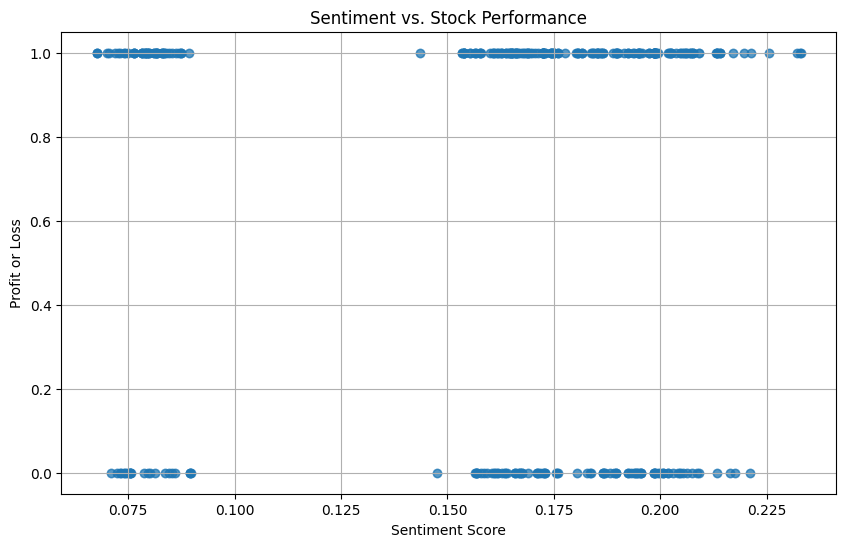

In [128]:

# Load the combined sentiments data
sentiments_file = 'data/sentiments/combined_monthly_avg_sentiment.csv'  # Update with your actual file path
sentiments_df = pd.read_csv(sentiments_file)

# Load the combined stock profit or loss data
stock_file = 'data/stock_data/all_tickers_monthly_profit_or_loss.csv'  # Update with your actual file path
stock_df = pd.read_csv(stock_file)

# Ensure the 'Year_Month' is a consistent format in both dataframes
sentiments_df['Year_Month'] = pd.to_datetime(sentiments_df['Year_Month']).dt.to_period('M')
stock_df['Year_Month'] = pd.to_datetime(stock_df['Year_Month']).dt.to_period('M')

# Merge the datasets on Ticker and Year_Month
merged_df = pd.merge(sentiments_df, stock_df, on=['Ticker', 'Year_Month'], how='inner')

# Save the merged data to a CSV file
output_file = 'data/analysis/sentiments_vs_stock_performance.csv'
merged_df.to_csv(output_file, index=False)

print(f"Merged dataset saved to {output_file}")



plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Average_Sentiment'], merged_df['Profit_or_Loss'], alpha=0.5)
plt.title('Sentiment vs. Stock Performance')
plt.xlabel('Sentiment Score')
plt.ylabel('Profit or Loss')
plt.grid(True)
plt.show()


C:\Users\asare\AppData\Local\Temp\ipykernel_7248\3048649673.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')


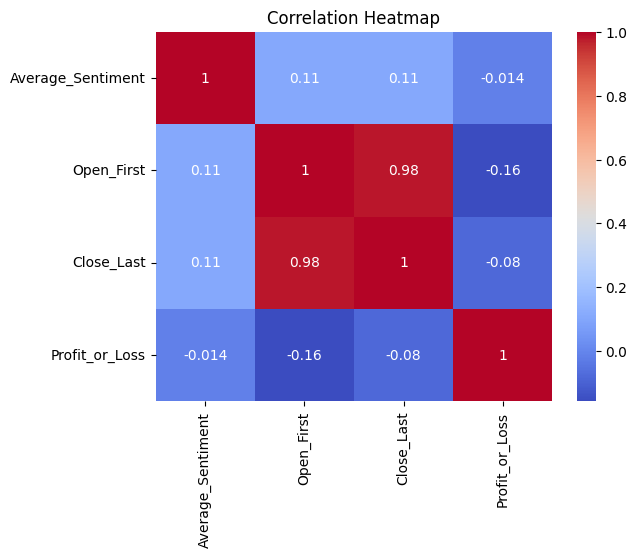

In [130]:
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


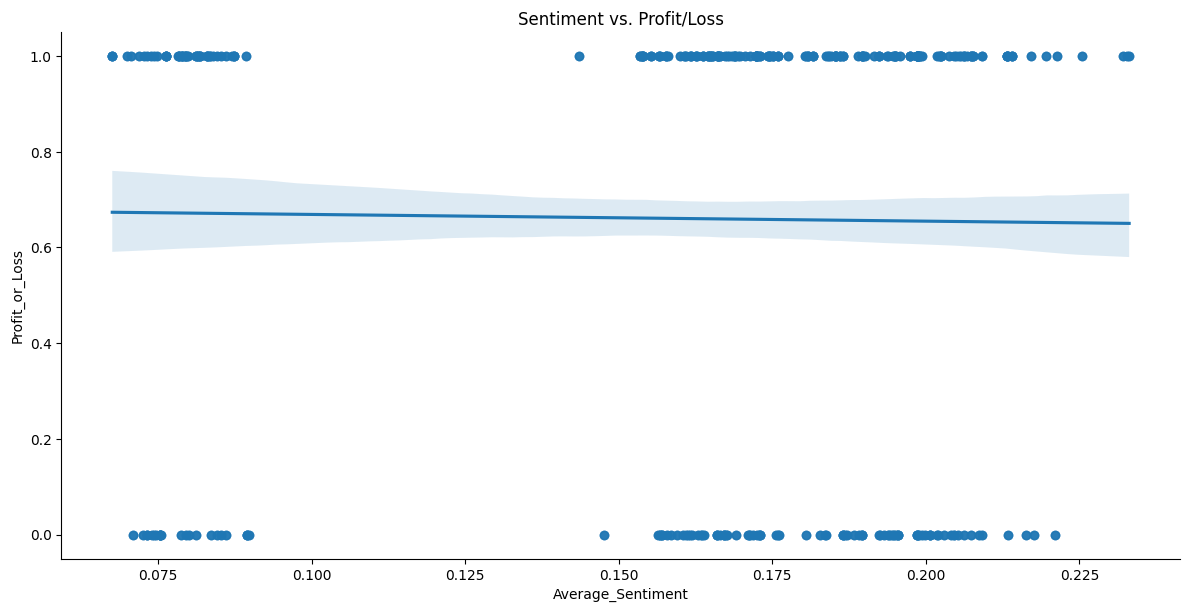

In [132]:
sns.lmplot(x='Average_Sentiment', y='Profit_or_Loss', data=merged_df, aspect=2, height=6)
plt.title('Sentiment vs. Profit/Loss')
plt.show()

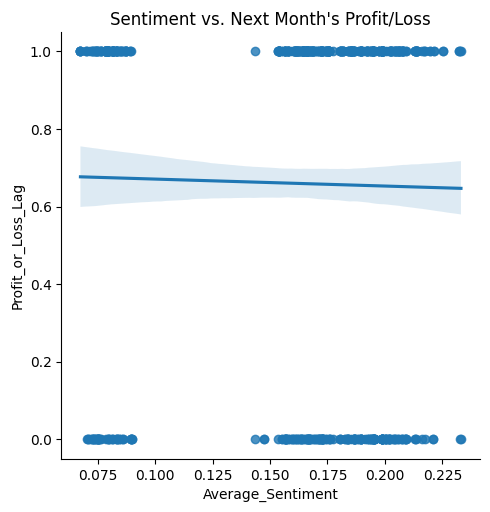

In [134]:
merged_df['Profit_or_Loss_Lag'] = merged_df['Profit_or_Loss'].shift(-1)  # Shift profit/loss by one period
sns.lmplot(x='Average_Sentiment', y='Profit_or_Loss_Lag', data=merged_df)
plt.title('Sentiment vs. Next Month\'s Profit/Loss')
plt.show()
